# Data Analysis
# "Classification" 2 – Tree-based models

In this lecture, we'll discuss:
* more classification methods based on trees (...and regression)
* ensemble methods (bagging and boosting)
* generalizability and cross validation (we **always** talk about that)

You should install these two libraries to draw decision trees:
* PyDotPlus: `conda install pydotplus`
* GraphViz: Go [here](https://www.graphviz.org/download/) to download the app. On Mac and with homebrew you can run `brew install graphviz`. 

Recommended Reading: 
* G. James, D. Witten, T. Hastie, and R. Tibshirani, An Introduction to Statistical Learning, Chapter 8 [digital version available here](http://www.statlearning.com)
* [Visual Intro to Machine Learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
* [Blog post](http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-29.html)
* [Scikit learn documentation](http://scikit-learn.org/stable/modules/tree.html)

In [24]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
#plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

# 0. Classification

Recall that in *classification* we attempt to predict a categorical variable based on based on several features or attributes. 

We've already seen two methods for classification: 
1. Logistic Regression
+ k Nearest Neighbors (k-NN)

Today, we'll discuss tree-based models and explain how they can be used for either classification or regression.

## 0.1 What are Decision Trees?

[Decision trees](https://en.wikipedia.org/wiki/Decision_tree_learning) are very intuitive classification and regression tools. 

Consider the following [decision tree from the New York Times](https://archive.nytimes.com/www.nytimes.com/imagepages/2008/04/16/us/20080416_OBAMA_GRAPHIC.html), 
which predicts whether a county voted for Obama or Clinton in the 2008 democratic primary. 

<img src="oc-tree.jpeg" width="500">




Here is another decision tree for the survival of passengers on the titanic.  The figures under the leaves show the probability of survival and the percentage of observations in the leaf.

![](titanic_tree.png)

The use of a decision tree is very simple. Suppose someone gives you this tree and a new person. In order to predict whether or not the person would have died on the titanic, you ask the following questions, in order:

 * Is the person male? If no, we predict they would have survived. If yes, continue.
 * Is the person older than 9.5 years? If yes, we predict they would have died. If no, continue.
 * Did the person have more than 3 or more siblings? If yes, we predict they would have died. If no, they would have survived.
 
Many of these decisions make intuitive sense: social convention gave women and children preference for rescue. Some, however, are not as obvious: why is having more than 3 siblings or spouses a marker? Could this be a marker for a hidden variable?

The question we'll move to now is: How would one create such a tree? 

# 1. Building a Decision Tree

Building a decision tree isn't really much harder than reading one. Learning the smallest ‘optimal’ decision tree for any given set of data is $NP$-complete for numerous simple definitions of ‘optimal’. Instead, we seek a reasonably good model using a greedy algorithm. 

There are many algorithms to do that (e.g. [ID3 algorithm](https://en.wikipedia.org/wiki/ID3_algorithm)) but the essential rundown would be: 

+ Start with an empty decision tree (undivided feature space) 
+ Choose the ‘optimal’ predictor on which to split and choose the ‘optimal’ threshold value for splitting. 
+ Recurse on on each new node until stopping condition is met

Now, we need only define our splitting criterion and stopping condition. 

Usually we say that the 'optimal' predictor is the one that creates a partition of data that the *error is minimized*. But what is an error?

Let's say we're building a classification tree by considering a list of predictors. In the Titanic example we want to be able to classify whether people have survived based on things like gender, age, the booked fare, etc. Let's call the variables $X_{i,p}$ ($i$ for passengers, $p$ for predictors). Initially, for the first split, we consider all the passengers and all the predictors. We also have an observed label $Y_i$ for each passenger. 

We can calculate the *mean error*, 
$$
ME = \frac{1}{N}\sum_{i=1}^N \ell(\hat{Y}_i, Y_i),
$$ 
where $\ell(\hat{Y}_i, Y_i)$ is the error for sample $i$. Here, the error would be 
* squared error for regression, *i.e.*, $\ell(\hat{Y}_i, Y_i) = (\hat{Y}_i - Y_i)^2$ and 
* either [*Entropy*](https://en.wikipedia.org/wiki/Cross_entropy) 
or 
[*Gini impurity*](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) 
for classification. See accompanying notebook for more info on e.g. how entropy works.


We want to achieve two things: pick the **best split** for the **best predictor**.

- At **each step** of the algorithm we consider a list of possible decisions or splits, *e.g.*, $X_{i,6} > 9$ (age is greater than 9), or $X_{i,5} = female$.
- For each possible decision we recalculate the predictor for that rule, for example $\hat{Y}_i = 1$ if $X_{i,6} > 9$ and $0$ otherwise.
- We recalculate the mean error for each possible decision
- We choose the decision that reduces the error by the largest amount.
- Then continue with the next step on the reduced input set.

In building decision trees, it is easy to overfit the data. There are several methods for avoiding this, which we'll discuss more below. Simple strategies include limiting the depth of a tree or only splitting when we have more than $N$ samples left. 


## 1.1 Decision Trees with SciKit Learn

Scikit-learn has [a nice decision tree implementation](http://scikit-learn.org/stable/modules/tree.html) which we'll use to learn a tree for the famous Titanic dataset.

We'll consider [a dataset of Titanic passengers](https://www.kaggle.com/c/titanic/) and develop a model to predict whether a particular passenger will survive or not. This is what [the dataset](titanic.csv) looks like:


| PassengerId | *Survived* | Pclass | Name                                                                               | Sex    | Age  | SibSp | Parch | Ticket             | Fare     | Cabin           | Embarked |
|-------------|----------|--------|------------------------------------------------------------------------------------|--------|------|-------|-------|--------------------|----------|-----------------|----------|
| 1           | 0        | 3      | Braund, Mr. Owen Harris                                                            | male   | 22   | 1     | 0     | A/5 21171          | 7.25     |                 | S        |
| 2           | 1        | 1      | Cumings, Mrs. John Bradley (Florence Briggs Thayer)                                | female | 38   | 1     | 0     | PC 17599           | 71.2833  | C85             | C        |
| 3           | 1        | 3      | Heikkinen, Miss. Laina                                                             | female | 26   | 0     | 0     | STON/O2. 3101282   | 7.925    |                 | S        |
| 4           | 1        | 1      | Futrelle, Mrs. Jacques Heath (Lily May Peel)                                       | female | 35   | 1     | 0     | 113803             | 53.1     | C123            | S        |
| 5           | 0        | 3      | Allen, Mr. William Henry                                                           | male   | 35   | 0     | 0     | 373450             | 8.05     |                 | S        |


Here are the variable descriptions for the non-obvious variables:
 * **Survived:**        (0 = No; 1 = Yes)
 * **pclass:**          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
 * **sibsp:**           Number of Siblings/Spouses Aboard
 * **parch:**           Number of Parents/Children Aboard
 * **ticket:**          Ticket Number
 * **fare:**            Passenger Fare
 * **cabin:**           Cabin
 * **embarked:**        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


We're trying to decide whether a passenger with particular attributes will survive the Titanic disaster, so the **survival** variable is our label, the other columns are the **features**. 

In [25]:
titanic = pd.read_csv("titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1.2 Data cleanup

We need to do some cleanup: 
 * Age has missing values. Let's assume that a person with missing age is of mean age (this is not necessarily a good decision. Why?).
 * Embarked has missing values, we add a dedicated category for unknown embarkation points.
 * We need to convert the categorical values to numerical values. 

In [26]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].mean())

def sex_to_numeric(x):
    if x=='male':
        return 0
    if x=='female':
        return 1
    else:
        return x

titanic["Sex"] = titanic["Sex"].apply(sex_to_numeric)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [27]:
# this will break if run more than once
def embarked_to_numeric(x):
    if x=="S":
        return 0
    if x=="C":
        return 1
    if x=="Q":
        return 2
    else: 
        return 3
    
titanic["Embarked"] = titanic["Embarked"].apply(embarked_to_numeric)
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,8.0500,NaN,0
5,6,0,3,"Moran, Mr. James",0,29.699118,0,0,330877,8.4583,NaN,2
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.000000,0,0,17463,51.8625,E46,0
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.000000,3,1,349909,21.0750,NaN,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.000000,0,2,347742,11.1333,NaN,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.000000,1,0,237736,30.0708,NaN,1


Let's work only with the numerical and categorical variables and omit passengerID, Name, Ticket and Cabin. These values could contain some information, but it's hard to make sense of them without more context.

In [28]:
features = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
titanic = titanic[features]
titanic.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.000000,1,0,7.2500,0
1,1,1,1,38.000000,1,0,71.2833,1
2,1,3,1,26.000000,0,0,7.9250,0
3,1,1,1,35.000000,1,0,53.1000,0
4,0,3,0,35.000000,0,0,8.0500,0
5,0,3,0,29.699118,0,0,8.4583,2
6,0,1,0,54.000000,0,0,51.8625,0
7,0,3,0,2.000000,3,1,21.0750,0
8,1,3,1,27.000000,0,2,11.1333,0
9,1,2,1,14.000000,1,0,30.0708,1


## 1.3 Exploring the data

Let's take a look at the data:

In [29]:
titanic.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.368126
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.647601
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000


**Questions:**
1. What percentage of passengers survived? 
+ What percentage of passengers are female?

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


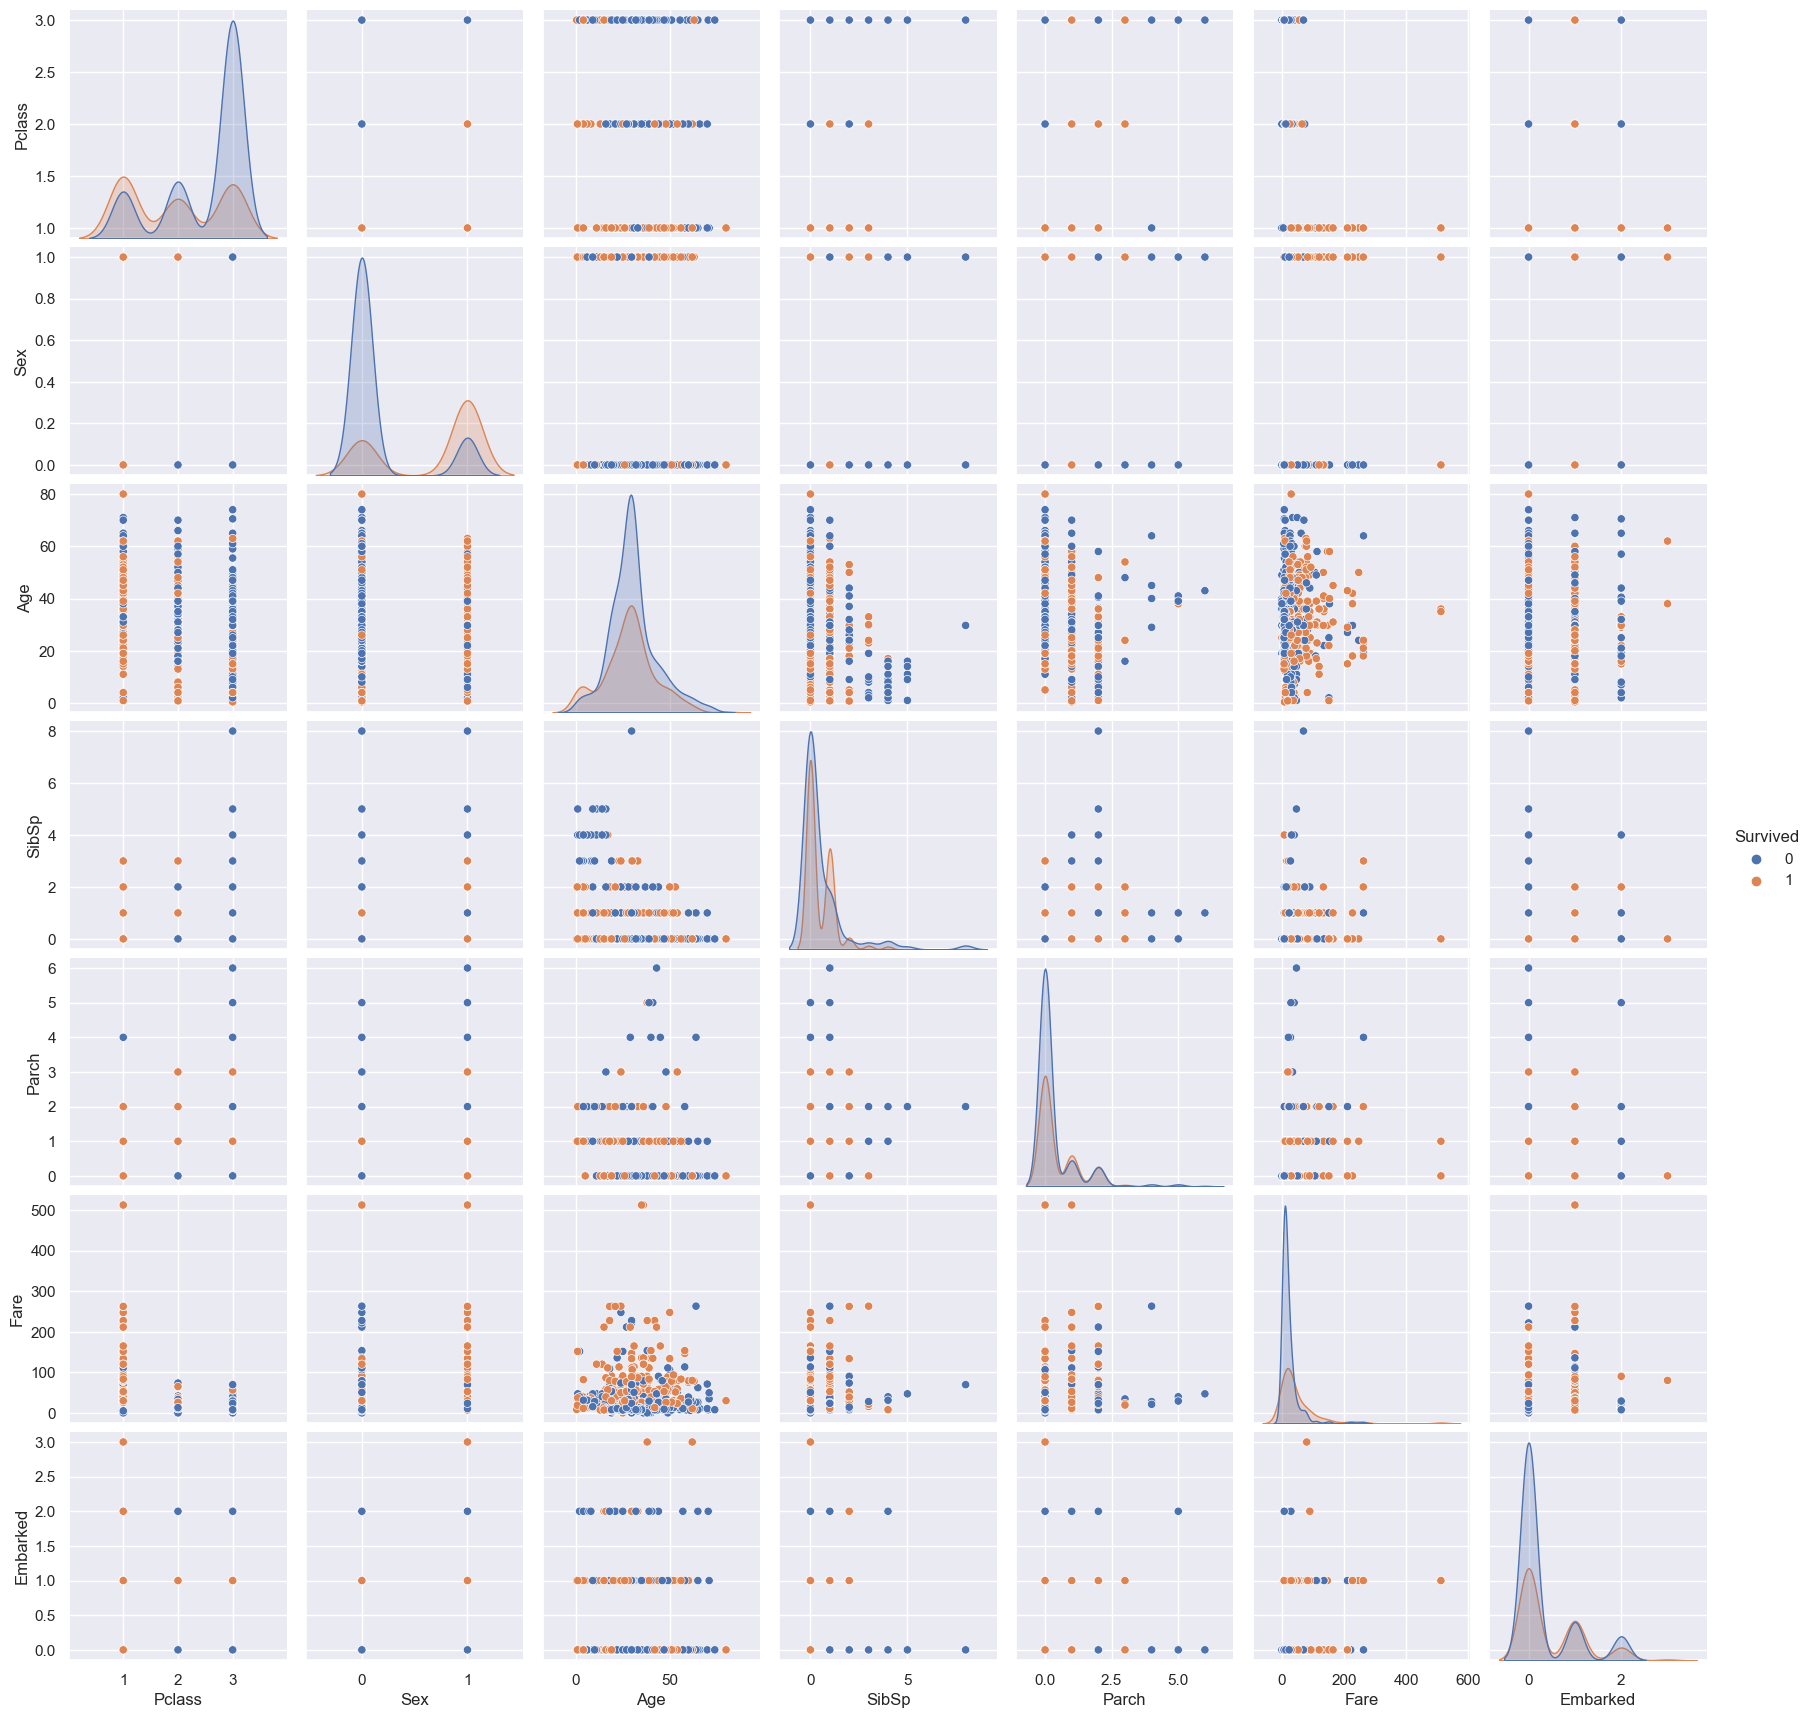

In [30]:
import seaborn as sns
sns.set()
sns.pairplot(titanic, hue="Survived");

## 1.4 Our first tree

We are using two functions below:

+ Split data into training and test set and also select some features
+ Plot decision trees (without getting any weird errors...)

In [31]:
#labels =["Survived", "Perished"]

def splitData(features):
    """Split a subset of the titanic dataset, given by the features, into train and test sets."""
    titanic_predictors = titanic[features].values
    titanic_labels = titanic["Survived"].values

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(titanic_predictors, titanic_labels, random_state=1, test_size=0.5)
    return XTrain, XTest, yTrain, yTest

In [32]:
from IPython.display import Image, display  
import pydotplus 
from scipy import misc

def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["Perished", "Survived"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "temp.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

Now let's look at a decision tree that **ONLY operates on sex**! 

Accuracy on training data =  0.8112359550561797
Accuracy on test data =  0.7623318385650224


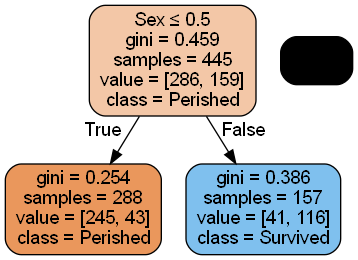

In [33]:
decisionTree = tree.DecisionTreeClassifier()

XTrain, XTest, yTrain, yTest = splitData(["Sex"])
# fit the tree with the traing data
decisionTree = decisionTree.fit(XTrain, yTrain)

# predict with the training data
y_pred_train = decisionTree.predict(XTrain)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(XTest)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

renderTree(decisionTree, ["Sex"])

~76% correct on the test set isn't bad! - sex seems to be a very good indicator of whether someone has survived or not. But let's increase the complexity a bit...

## 1.5 Adding more features

Accuracy on training data=  0.8337078651685393
Accuracy on test data=  0.7600896860986547


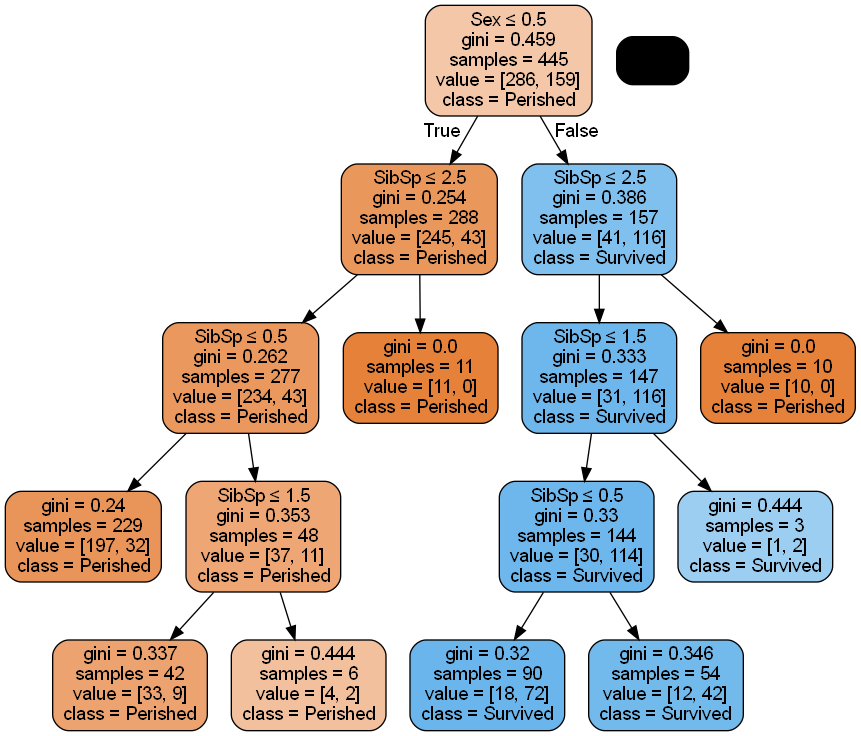

In [34]:
#  train tree on sex and the number of the number of siblings/spouses aboard
used_features = ["Sex", "SibSp"]
XTrain, XTest, yTrain, yTest = splitData(used_features)
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, used_features)

Our accuracy on the training data has gone up, but the accuracy on the test data has gone down. It might be that we are down the road to overfitting... But maybe we just selected the wrong features? "Let's just try all of them" (famous last words of the data scientist).

Accuracy on training data=  0.9887640449438202
Accuracy on test data=  0.7488789237668162


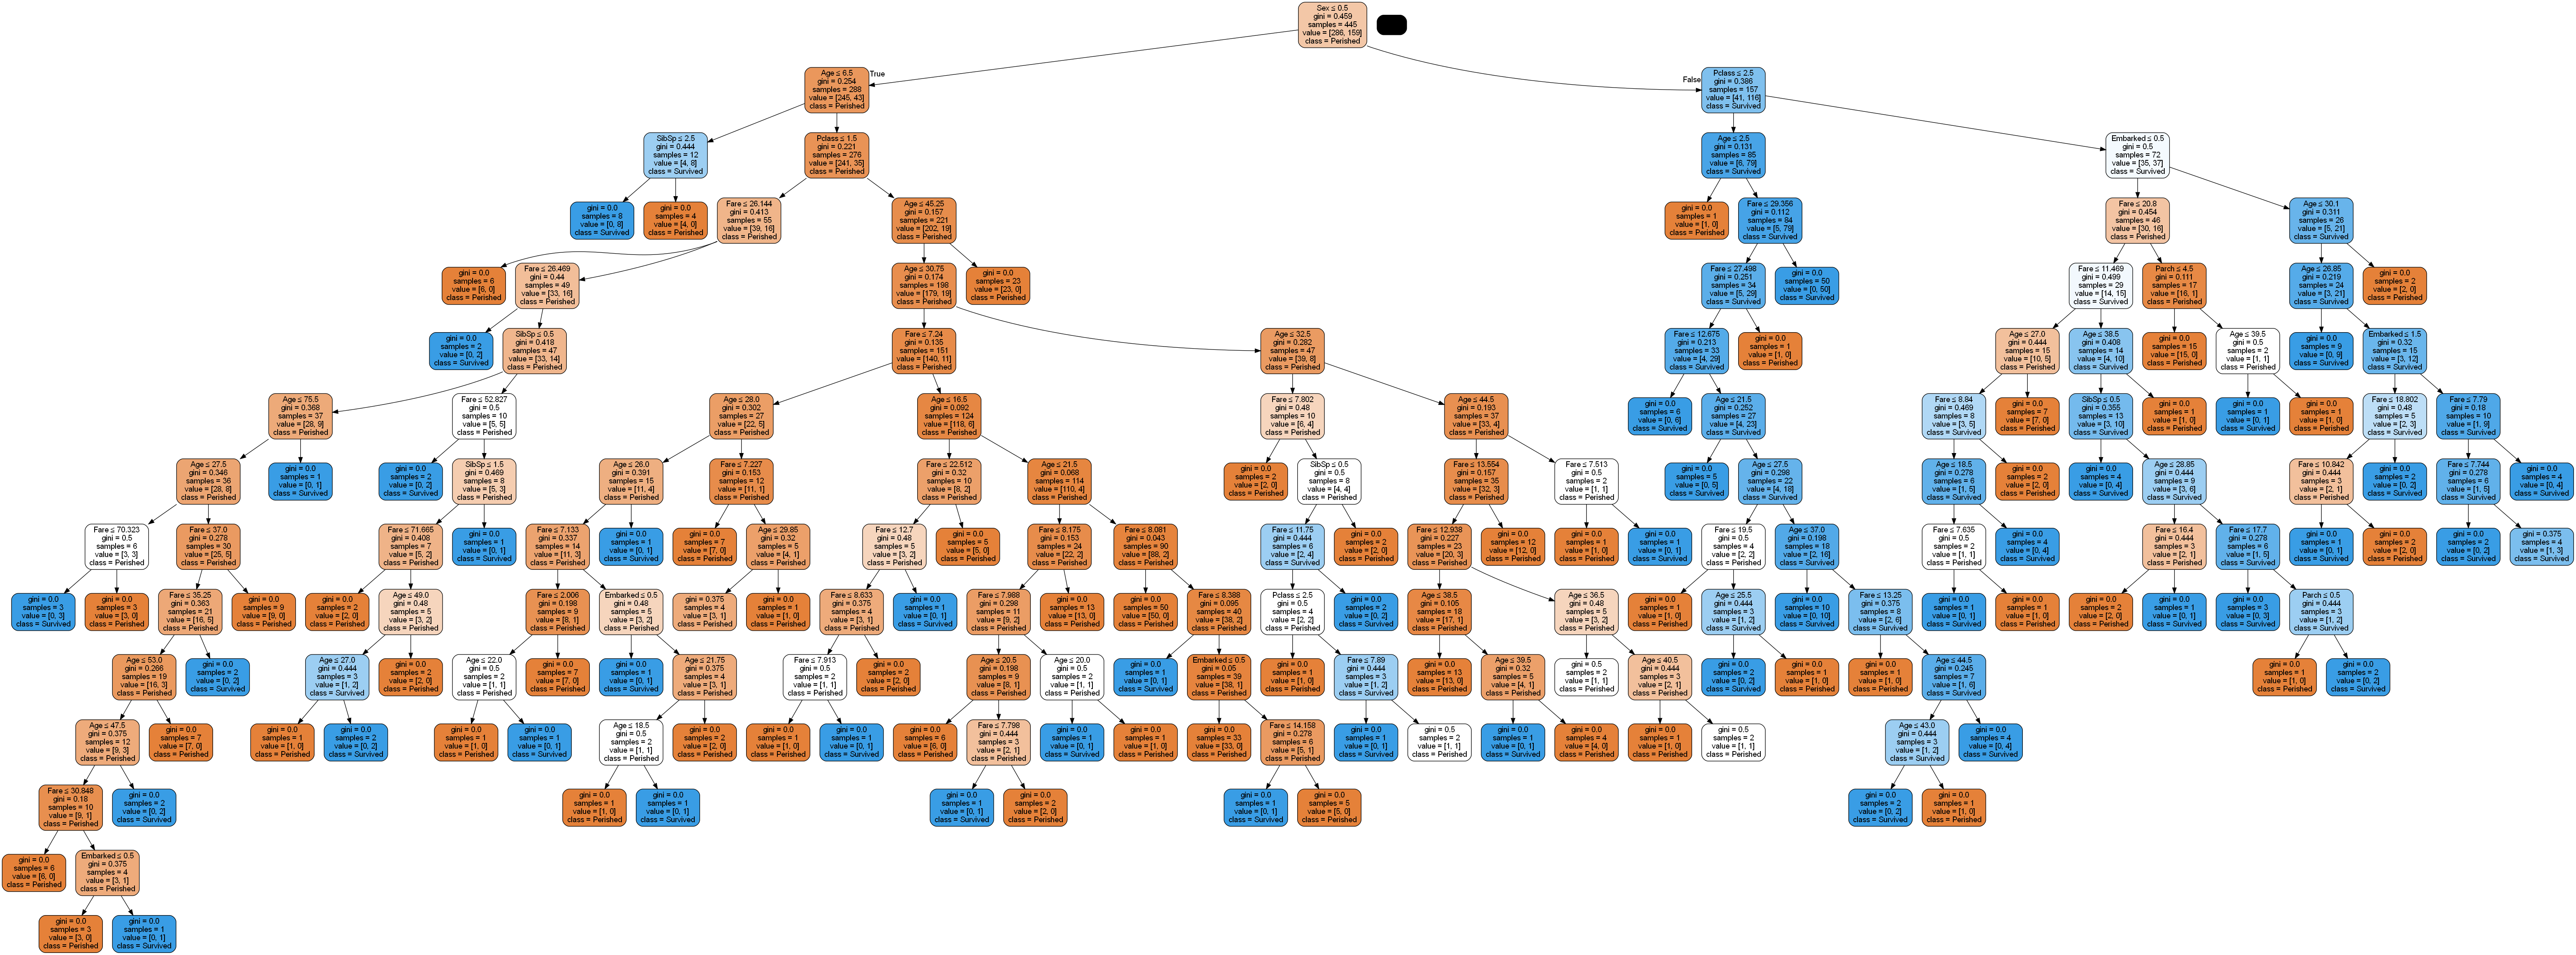

In [35]:
all_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

XTrain, XTest, yTrain, yTest = splitData(all_features)
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

If you were not persuaded before, now it should be clear that we are overfitting the data - 98% accuracy on the training data and only ~76% on the test data. Also, in case you didn't notice, we've created a complicated tree that is almost impossible to read.

Decision trees are notorious for overfitting the data. There are two parameters that help us hold the fort against the curse of overfitting:

* **max_depth:** The maximum depth of the tree. If this is not set, then nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples.
* **min_samples_split:** The minimum number of samples required to split an internal node: If the value is an integer, then consider `min_samples_split` as the minimum number. If it is float, then `min_samples_split` is a percentage and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split.

Let's try combinations of depth and min split size:

Accuracy on training data=  0.8629213483146068
Accuracy on test data=  0.7937219730941704


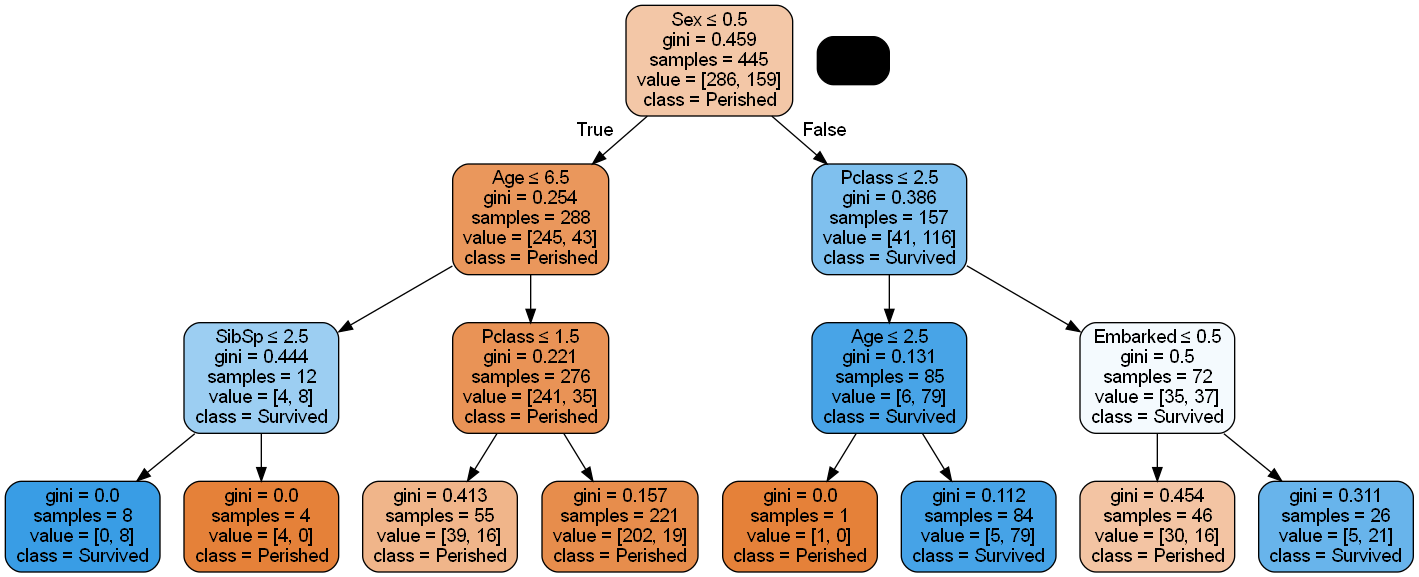

In [43]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

Accuracy on training data=  0.8943820224719101
Accuracy on test data=  0.7757847533632287


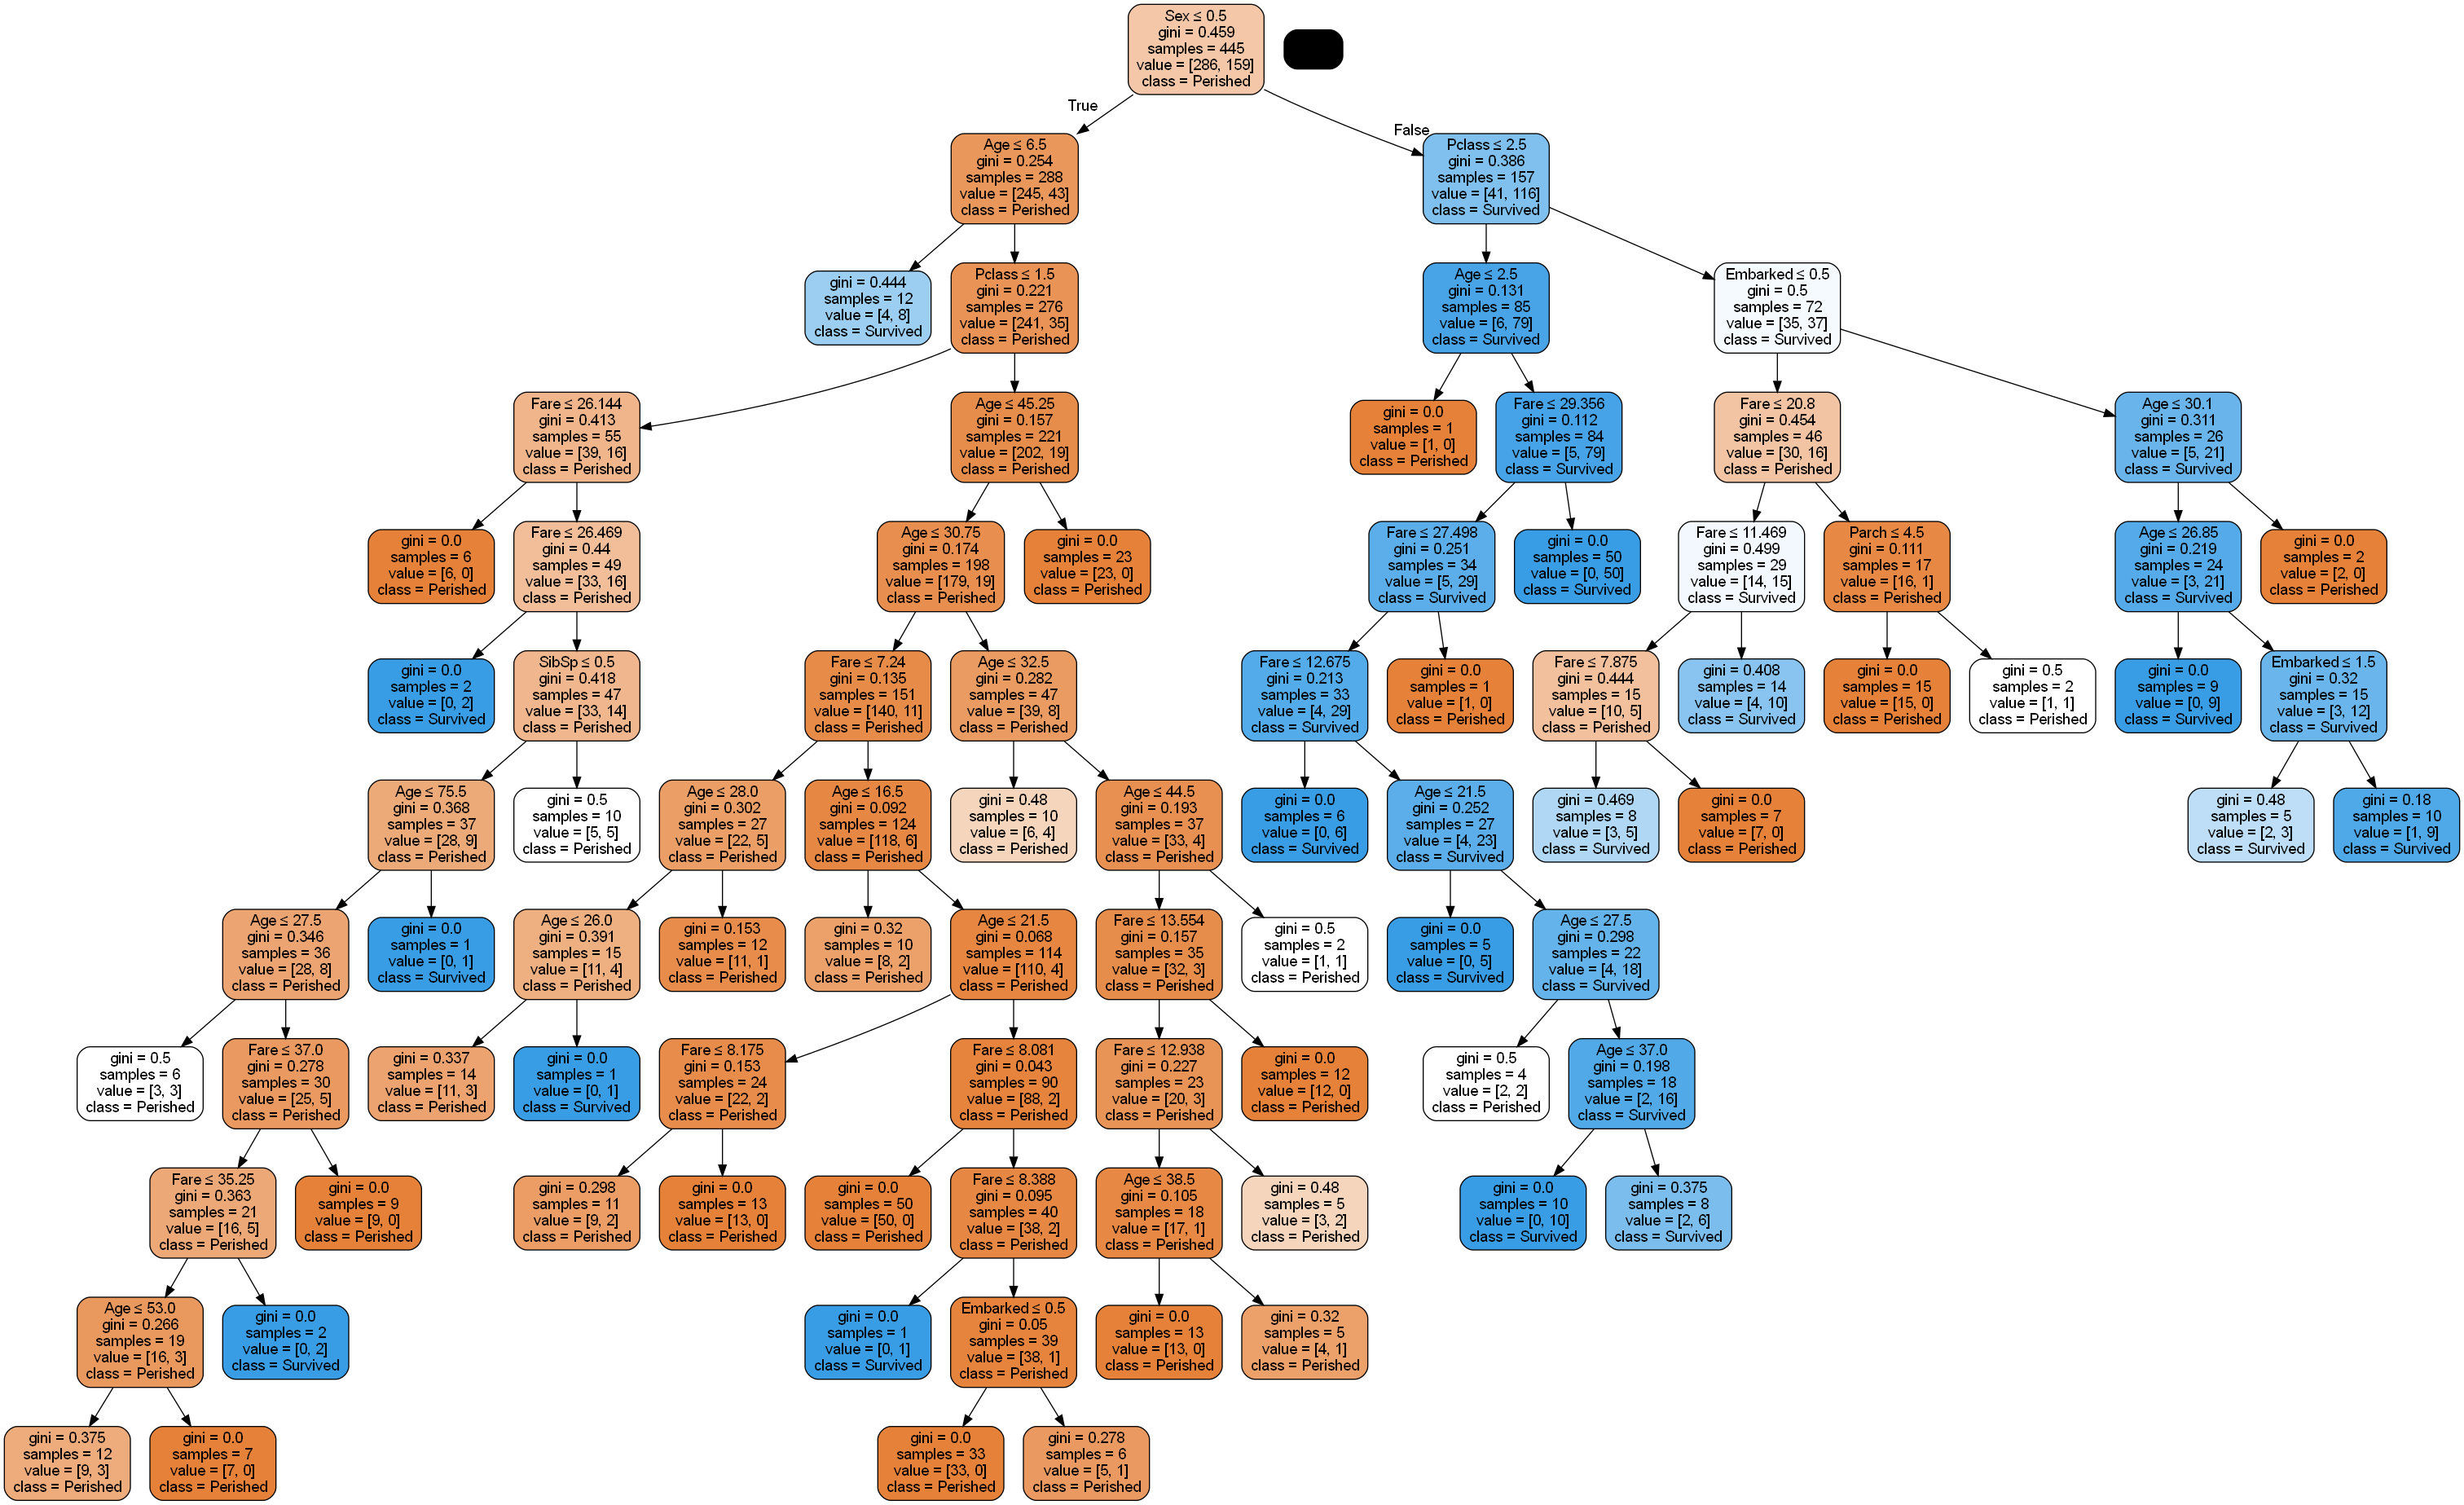

In [44]:
decisionTree = tree.DecisionTreeClassifier(min_samples_split=15)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

Accuracy on training data=  0.8629213483146068
Accuracy on test data=  0.7937219730941704


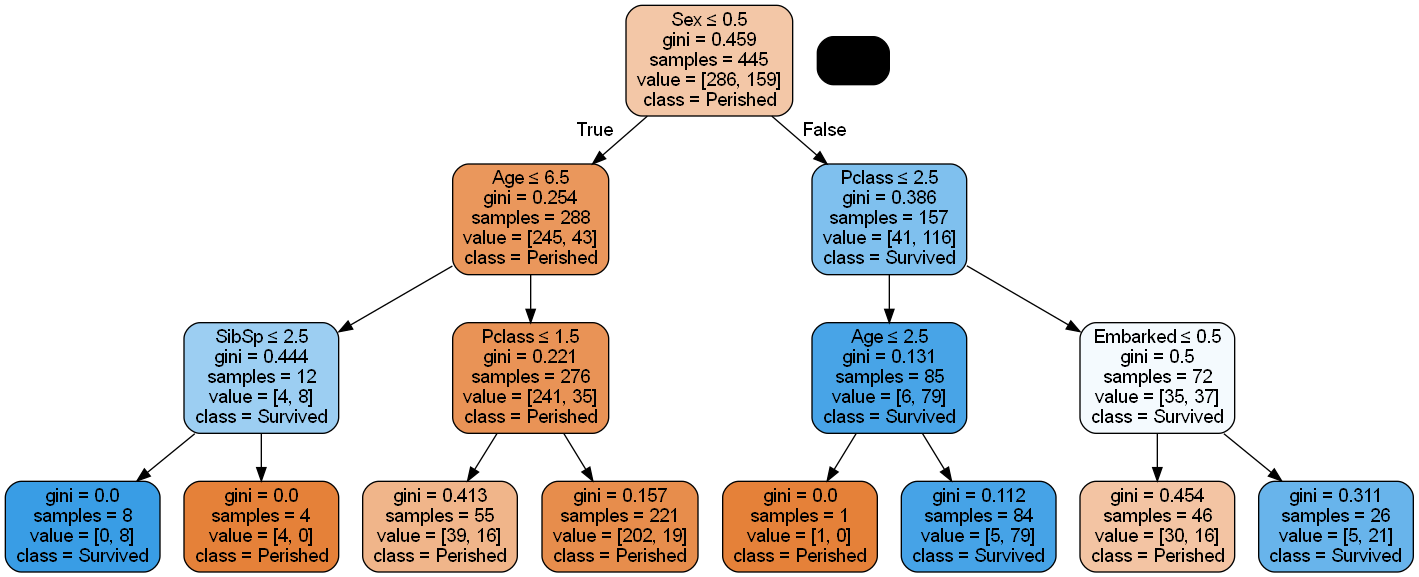

In [38]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3, min_samples_split=10)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

It looks like both, the minimum number of samples for splitting and the maximum depth help with overfitting and we achieve a 79-80% accuracy rate on the test set. That doesn't sound much better than just gender alone, but 4% improvement might be considered a lot in binary classification (depending on the application).

Also, our last model is fairly simple yet quite accurate. The main point seems to be:

 * Sex is the dominant factor at the root of the tree
 * For females, if you're in class 1 or 2 you're almost guaranteed to jump on a boat (and survive)
 * For males, if you were younger than 6.5 years old, you had a chance to survive. 
 * Also note that there are branches that predict the same thing, but with different certainty. For example, in the male / adult category, if you were in "first class", you still were likely to die, but less likely than in second or third. 

## 1.6 Discussion 

### Advantages of decision trees
* Decision trees are simple to explain and interpret
* There is a nice graphical display for trees
* Easy to handle categorical predictors (no dummy variables needed)

### Disadvantages of decision trees
* Decision trees generally don't have the predictive accuracy of other approaches as they tend to overfit the data. 
* Decision trees are non-robust, *i.e.*, sensitive to small changes in the data. They demonstrate high variance.

Both of these disadvantages are addressed by the following, more advanced methods. 

# 2. Ensemble Methods based on Decision Trees

Ensemble Methods (Ensemble Learning) use multiple algorithms at the same time and then come to a consensus of a predictive label. 

Two main directions can be identified here (with many variations):

1. **Bagging** (Bootstrap Aggregating). The idea of [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) is to generate several trained models (e.g., decision trees) based on subsets of the data and let the decision trees vote to arrive at a prediction. Commonly the subset is chosen through bootstrapping, i.e., random sampling with replacement. Since averaging a set of observations reduces variance, this increases the predictive accuracy of the method. 

+ [**Boosting**](https://en.wikipedia.org/wiki/Boosting_(machine_learning)) is similar to bagging, except that the trees are grown sequentially and are trained specifically to address errors we make in early steps.  

Ensemble methods are generally of higher accuracy, but also take a lot longer to train. 

**POLL**

Without cheating, respond:

Which year was the Titanic movie out?



## 2.1 Bagging

One way to adjust for the high variance of the output of an experiment is to perform the experiment multiple times and then average the results. 

The same idea can be applied to high variance models (like decision trees) in 2 steps: 
1. (Bootstrap) We generate multiple samples of training data, via *bootstrapping*: We train a full decision tree on each sample of data. Bootstrapping is *random sampling* with replacement (i.e. we sample from the dataset and replace whatever we have "taken", meaning that one data point can be used for training multiple trees.

2. (Aggregate) for a given input, we output the averaged outputs of all the models for that input. For classification, we return the class that is decided by the majority of the models (majority voting).

Since we have many trees that we will **average over for prediction**, we can choose a large `max_depth` and we are ok as we will rely on the law of large numbers to shrink this large variance, low bias approach for each individual tree.

![bagging](bagging.png)

### Pros of Bagging

Bagging enjoys the benefits of 
1. High expressiveness - by using full trees each model is able to approximate complex functions and decision boundaries. 
2. Low variance -averaging the prediction of all the models reduces the variance in the final prediction, assuming that we choose a sufficiently large number oftrees. 

An added bonus of bagging (and bootstrapping) is that the left off data points can be used as a "natural" validation set. That is called the *Out Of Bag* (OOB) sample. 

### Cons of Bagging

The major drawback of bagging (and other ensemble methods ) is that the averaged model is no longer easily or directly interpretable - i.e. one can no longer trace the ‘logic’ of an output through a series of decisions 
based on predictor values! 

Moreover, in practice, the ensembles of trees in bagging tend to be highly correlated. Suppose we have an extremely strong predictor, $x_j$, in the training set amongst moderate predictors. Then the greedy learning algorithm ensures that most of the models in the ensemble will choose to split on $x_j$ in early iterations. That is, each tree in the ensemble is identically distributed, with the expected output of the averaged model the same as the expected output of any one of the trees. 

## 2.1.1 Random Forests (RF)

Bagging alone is not enough randomization, because even after bootstrapping, we are mainly training on the same data points using the same variables and that might lead to correlated trees.

Random Forest is a modified form of bagging, where we will build each tree by splitting on a "random" subset of predictors at each split (hence, each is a 'random tree'!).  This can't be done in with just one predictor, but with more predictors we can choose which predictors to split on randomly and how many to do this on.  Then we combine many 'random trees' together by averaging their predictions, and this gets us a forest of random trees: a **random forest**.

### Hyperparameters of Random Forests

Random forest models have multiple hyper-parameters to tune: 
1. the number of predictors $m$ to randomly select at each split (typically, $m= \sqrt p$, where $p$ is the number of predictors) (`max_features` in `sklearn`)
2. the total number of trees in the ensemble (`n_estimators` in `sklearn`)
3. the minimum leaf node size / max depth / minimum samples split (same as decision trees).

Most likely, you want to do cross-validation for identifying the first two hyperparameters and for the third one: in theory, each tree in the random forest is full, but in practice this can be computationally expensive (and adds 
redundancies to the model), thus, imposing a minimum node size is not unusual. 

In [45]:
from sklearn.ensemble import RandomForestClassifier

forest =  RandomForestClassifier(bootstrap=True, max_features=2, n_estimators=100, random_state=0)

trained_forest = forest.fit(XTrain, yTrain)

y_pred_train = trained_forest.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = trained_forest.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  0.9865168539325843
Accuracy on test data=  0.7937219730941704


### Variable importance: Why we love Random Forests

For bagged/RF regression trees, we *record* the total amount that the RSS is decreased due to splits over a given predictor, averaged over all trees. A large value indicates an important predictor. 

Similarly, for bagged/RF classification trees, we add up the total amount that the metric (used for splitting e.g. Entropy) is improved by splits over a given predictor, averaged over all trees. 

    Feature  Importance
1       Sex   29.695765
5      Fare   24.388967
2       Age   24.189504
0    Pclass    7.792520
3     SibSp    6.206585
4     Parch    4.037526
6  Embarked    3.689133


<Axes: xlabel='Feature'>

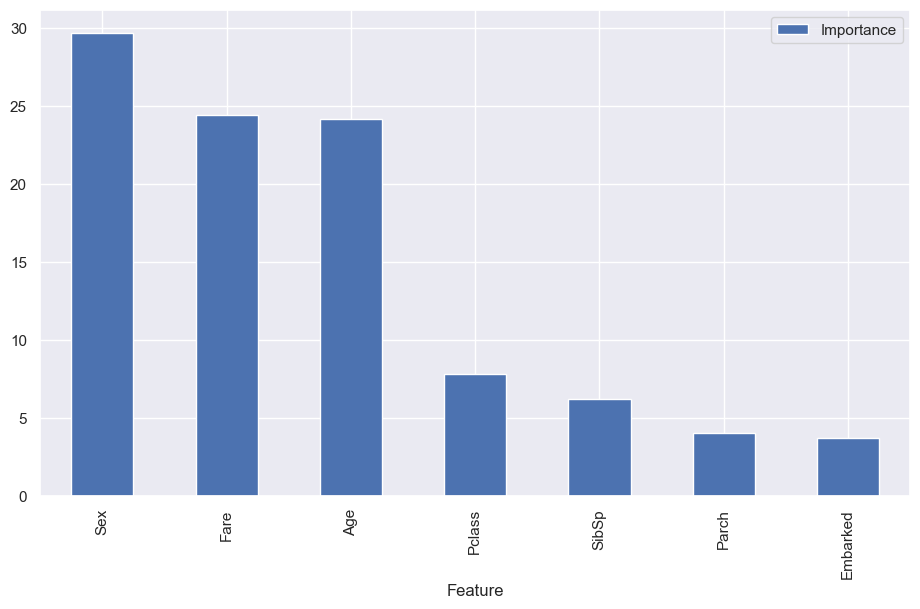

In [40]:
imp = {'Feature':all_features,'Importance':forest.feature_importances_*100}

d_imp = pd.DataFrame(imp).sort_values(by='Importance', ascending=False)
print(d_imp)

d_imp.plot.bar(x='Feature', y='Importance')


## 2.1.2 Thoughts on Random Forests 

When the number of predictors is large, but the number of 
relevant predictors is small, random forests can perform poorly.

- In each split, the chances of selecting a relevant predictor will be 
low and hence, most trees in the ensemble will be weak models. 

Increasing the number of trees in the ensemble generally does not increase the risk of overfitting 

- By decomposing the generalization error in terms of bias 
and variance, we see that increasing the number of trees 
produces a model that is at least as robust as a single tree. 
- However, if the number of trees is too large, then the trees 
in the ensemble may become more correlated, and that increases the 
variance. 

## 2.2 Boosting 

So far, none of the ensemble models we discussed has the ability to learn from its final predictions (or mistakes on these), which is what boosting allows us to do. In bagging/RF, we train different models iteratively over data (possibly multiple iterations), but the final predictions/errors are never used to train new models.

Boosting allows us to do exactly this, and it tends to use a bunch of 'weak' models. The reason for using weak models is that if we used very expressive models, our combined models would likely overfit pretty quickly. In short, we should learn from our models' mistakes.

Boosting is a general approach that can be applied to many statistical learning methods for regression or classification (It's like regularization: they are techniques applied to any learning model).

Gradient Boosting is typically used for regression tasks, as this method models the residuals (errors) and tries to improve them. AdaBoost is typically used for classification tasks.

AdaBoost explicitly weights the data points in the dataset based on the previous model's misclassifications. That is, our dataset is constantly being "re-weighted" (so practically changed) after each model, based on the misclassification from our accumulative model. Moreover, the model's accuracy is used for determining how much weight (aka, how much stock or faith) we should place on that given model. In the figure below, you see how AdaBoost works.

Let's see the parameters of boosting, before we do a review of all algorithms we saw today via the slides accompanying this notebook.

![boosting](boosting.png)

### Parameters of boosting

1. The number of trees $q$. Unlike bagging and random forests, boosting can overfit if $q$ is too large, although this overfitting tends to occur slowly if at all. We use cross-validation to select $q$.

+ The shrinkage parameter $\lambda$, a small positive number (in `sklearn` that is called `learning_rate`). This controls the rate at which boosting learns (i.e. how much I take into account each new iteration). Typical values are 0.01 or 0.001, and the right choice can depend on the problem. Very small $\lambda$ can require using a very large value of $q$ in order to achieve good performance. 

+ The number of splits $d$ in each tree, which controls the complexity of the boosted ensemble. Often $d = 1$ works well, in which case each tree is a stump, consisting of a single split and resulting in an additive model. More generally $d$ is the interaction depth, and controls the interaction order of the boosted model, since $d$ splits can involve at most $d$ variables.

In [41]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

clf = AdaBoostClassifier(n_estimators=100, learning_rate=1, random_state=0)
clf.fit(XTrain, yTrain)
AdaBoostClassifier(n_estimators=100, random_state=0)

#clf.predict([[0, 0, 0, 0]])
#array([1])
print('Accuracy on training data= ', clf.score(XTrain, yTrain))
print('Accuracy on testing data= ', clf.score(XTest, yTest))

Accuracy on training data=  0.8876404494382022
Accuracy on testing data=  0.7847533632286996


## 2.2.1 A note on XGBoost

XGBoost is a highly scalable implementation of gradient boosting for decision trees. The implementation of the algorithm was engineered for efficiency of computing time and memory resources (by actually taking into account which resources are available to train the model). 

![xgboost](xgboost.png)

See a video of the presentation [here](https://www.youtube.com/watch?v=Vly8xGnNiWs&ab_channel=DataScience.LA)

XGBoost has "destroyed" competition in tabularized datasets for regression or classification, however, there are cases that you should consider its use: 

* For image, NLP tasks 
* When few data points are available
* When # of features > # data points 

In [42]:
from xgboost import XGBClassifier

# fit model on training data
model = XGBClassifier(use_label_encoder=False, eval_metric="error")
model.fit(XTrain, yTrain)

print(model)

out1=model.predict(XTrain)
outputs= [round(value) for value in out1]


y_pred = model.predict(XTest)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = metrics.accuracy_score(yTest, predictions)
print("\nAccuracy on training data: %.2f%%" % (metrics.accuracy_score(yTrain,outputs) * 100.0))
print("Accuracy on testing data: %.2f%%" % (accuracy * 100.0))

ModuleNotFoundError: No module named 'xgboost'